In [1]:
import matplotlib.pyplot as plt
import numpy as np

from frechet_fda.tools.data_generation_tools import (
    gen_params_scenario_one,
    gen_truncnorm_pdf_points,
    make_estimated_truncnorm_pdf,
    make_truncnorm_pdf,
)
from frechet_fda.tools.function_tools import (
    frechet_mean,
    get_optimal_range,
    inverse_log_qd_transform,
    log_qd_transform,
    make_function_objects,
    mean_func,
)
from frechet_fda.tools.fda_tools import (
    compute_mean_and_centered_data,
    compute_cov_function,
    compute_principal_components,
    gen_qdtransformation_pcs,
    k_optimal,
    karhunen_loeve,
    mode_of_variation,
    total_frechet_variance,
)

In [2]:
# Set parameters
n = 200
grid_size = 2000
trunc = 3
mus, sigmas = gen_params_scenario_one(n)
# Sort sigmas just for inspection reasons
sigmas.sort()

In [3]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(
    -trunc, trunc, mus, sigmas, grid_size=grid_size, warn_irregular_densities=False,
)
# Make lists of Function class objects
my_pdfs = make_function_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0],
        new_ranges[i][1],
        mus[i],
        sigmas[i],
        grid_size=grid_size,
        warn_irregular_densities=False,
    )[0]
    for i in range(n)
]

C:\Coding\frechet_fda\src\frechet_fda\tools\numerics_tools.py:62: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)


In [4]:
# Generate all the distribution objects
new_pdfs = make_function_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

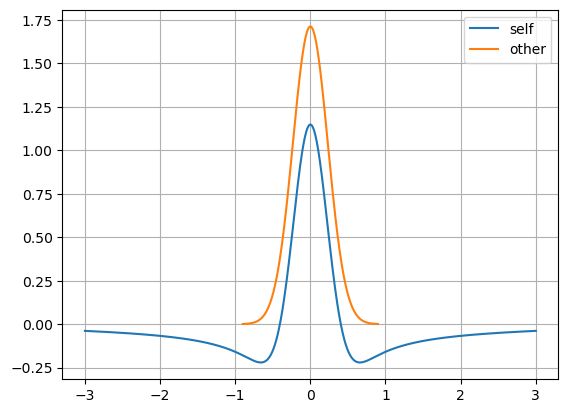

In [5]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
pdf_of_interest = sigmas.argmin()
mean_pdf, centered_pdfs = compute_mean_and_centered_data(new_pdfs)
centered_pdfs[pdf_of_interest].compare(new_pdfs[pdf_of_interest])

In [6]:
covariance_function = compute_cov_function(centered_pdfs)

In [7]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x,
    covariance_function,
)

## Transformation FPCA

In [10]:
def inverse_log_qd_transform(
    transformed_funcs, left_bound : float, right_bound : float
):
    """Invert the log quantile density transform to get back into density space."""
    # First compute quantile function via natural inverse
    natural_qfs = [func.exp().integrate() for func in transformed_funcs]
    # Compute correction factors to normalize quantiles
    thetas = [qf.y[-1] / (right_bound - left_bound) for qf in natural_qfs]
    corrected_qfs = [
        (qf / theta) + left_bound
        for qf, theta in zip(natural_qfs, thetas, strict=True)
    ]
    cdfs = [qf.invert() for qf in corrected_qfs]
    exponents = [
        func.compose(cdf) for func, cdf in zip(transformed_funcs, cdfs, strict=True)
    ]
    inverses = [
        theta / exponent.exp()
        for theta, exponent in zip(thetas, exponents, strict=True)
    ]

    return inverses

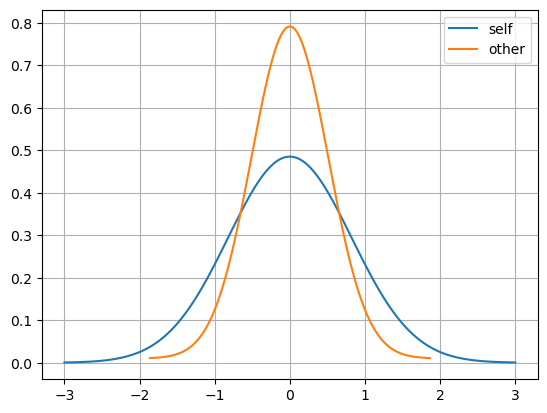

In [11]:
# Transform pdf sample, and test whether inverse works. Manually add some constant
# to help distinguish the curves
qf_of_interest = 50
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs, -trunc, trunc)
inverse_log_qdfs[qf_of_interest].compare(new_pdfs[qf_of_interest] + 0.01)

In [9]:
len(inverse_log_qdfs)

200

In [89]:
temp, theti, nqfs, cqfs, cdfs= inverse_log_qd_transform([log_qdfs[0] + log_qdfs[1]], -3, 3)

In [90]:
def get_optimal_range(funcs, delta: float = 1e-2) -> np.ndarray:
    """Get narrower support if density values are too small (smaller than delta).

    This is used so the qdfs dont get astronomically large at the boundaries and destroy
    numerical methods.
    
    Note: The method here assumes that the functions do have a compact
    support (even if it is narrower than the initial support). So if there is a point x1
    where func.y > delta is true, another point x2 > x1 where it is not, and then
    another x3 > x2 where it is true again, then x2 is included in the new range
    although it does not fullfill the condition.

    """
    new_ranges = np.zeros((len(funcs), 2))
    for i, func in enumerate(funcs):
        integrated_func = func.integrate()
        support_to_keep = func.x[
            (integrated_func.y > 0.5 * delta)
            & (1 - integrated_func.y > 0.5 * delta)
            & (func.y > delta)
        ]
        print(support_to_keep)
        new_ranges[i] = (support_to_keep[0], support_to_keep[-1])
    return new_ranges

[2.80373243 2.80527448 2.80657867 ... 2.84534301 2.84648403 2.84781359]
[2.80373243 2.80527448 2.80657867 ... 2.84534301 2.84648403 2.84781359]


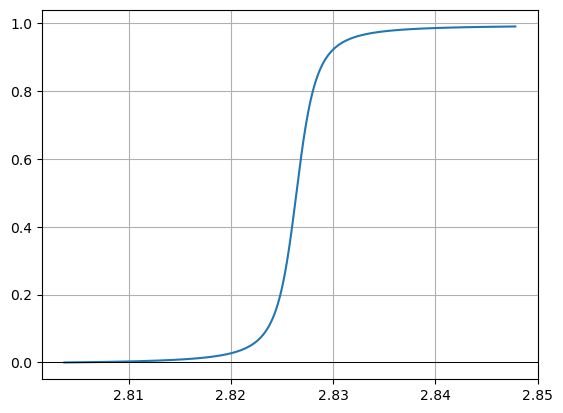

In [91]:
nqfs[0].y[-1], cqfs[0].y[-1]
si = temp[0].warp_range(get_optimal_range(temp)[0,0], get_optimal_range(temp)[0,1])
si.integrate().plot()

In [9]:
# Compute transformation FPCA objects
pcs_to_compute = 3
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs, k=pcs_to_compute)

In [10]:
eigenvalues_log_qdfs[0], eigenvalues_log_qdfs[1]

(0.3758988272292059, 0.02027602773879284)

In [20]:
# Karhunen-Loève decomposition of transforms
truncation_k = 1
truncated_representations_transforms = karhunen_loeve(
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
    K=truncation_k,
)

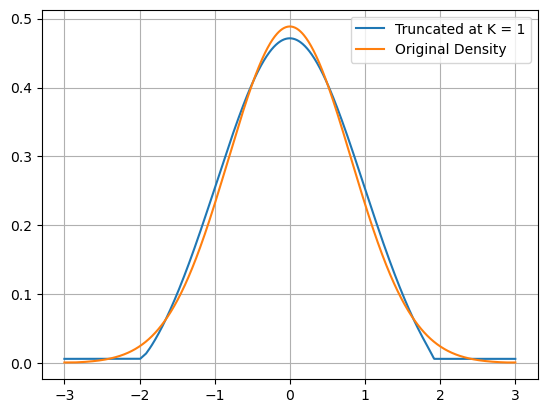

In [21]:
# Transform to density space. Compare truncated representation against real density
pdf_of_interest = 90
truncated_representations = inverse_log_qd_transform(
    truncated_representations_transforms,
    -trunc,
    trunc
)
truncated_representations[pdf_of_interest].warp_range(-trunc, trunc).compare(
    new_pdfs[pdf_of_interest].warp_range(-trunc, trunc),
    label_self=f"Truncated at K = {truncation_k}",
    label_other="Original Density",
)

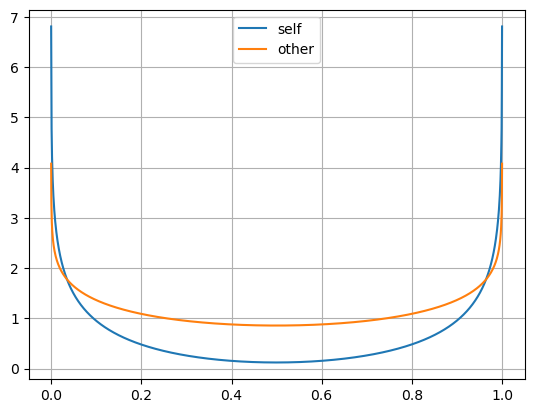

In [13]:
# Look at modes of variance of transformed functions
variation_modes_transforms = [
    mode_of_variation(mean_log_qdfs, eigval, eigfunc, alpha=1)
    for eigval, eigfunc
    in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs, strict=True)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

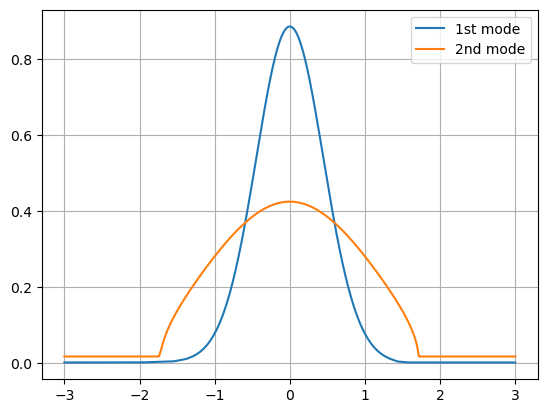

In [14]:
# Translate modes of variation to density space, compare first two modes
variation_modes = inverse_log_qd_transform(variation_modes_transforms, -trunc, trunc))
variation_modes[0].compare(
    variation_modes[1],
    label_self="1st mode",
    label_other="2nd mode",
)

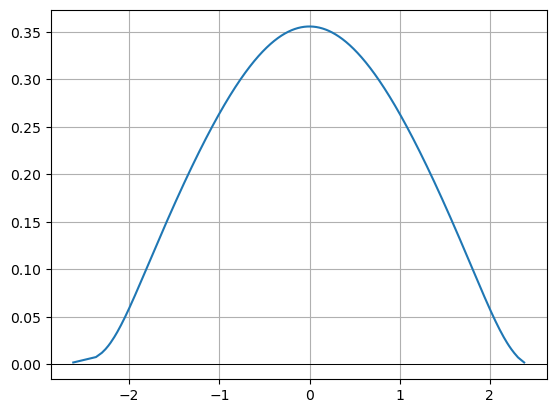

In [15]:
# Compute Fréchet mean
f_mean = frechet_mean(new_pdfs)
f_mean.plot()

In [16]:
# Compute Fréchet variance
total_variance = total_frechet_variance(f_mean, new_pdfs)

In [17]:
# Try function that finds optimal trunc representation
optimal_k, fraction_explained, truncated_representations = k_optimal(
    0.5,
    total_variance,
    new_pdfs,
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
)
optimal_k, fraction_explained

(1, 0.9902213275671985)

# Simulation

In [18]:
# Number of simulations
m = 5
# Number of samples of densities to generate
sample_sizes = [50, 100, 200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Bandwidth choice for density estimation
bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
grid_size = 1000
# Where to truncate normal distribution
trunc = 3
#
threshold_variance_explained = 0.9
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_f_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")

In [19]:
total_iterations = m * len(sample_sizes)  # Total iterations
current_iteration = 0  # Initialize a counter for the current iteration
print("Simulating...", end="\r")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        seed_num = int(str(i) + str(j))  # unique seed in each simulation run
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas just for inspection reasons
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(
            -trunc,
            trunc,
            mus,
            sigmas,
            grid_size=grid_size,
            warn_irregular_densities=False,
        )
        # Make Function class objects
        my_pdfs = make_function_objects(pdfs)

        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
                warn_irregular_densities=False,
            )[0]
            for i in range(n)
        ]

        # Generate numerically stable objects
        new_pdfs = make_function_objects(pdfs2)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(stored_f_means[i, j], new_pdfs)

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)
        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
            -trunc,
            trunc
        )

        ### And now again with additional density estimation step!
        which_kernel = "std_normal"
        sample_points = gen_truncnorm_pdf_points(
            -trunc, trunc, mus, sigmas, points_number
        )
        pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=-trunc * np.ones(n),
            b=trunc * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        new_ranges = get_optimal_range(pdf_hats)
        # Generate numerically stable objects, within individual ranges
        new_pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        # Compute Fréchet mean
        stored_f_means_denstimation[i, j] = frechet_mean(new_pdf_hats)
        stored_cs_means_denstimation[i, j] = mean_func(new_pdf_hats)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(
            stored_f_means_denstimation[i, j], new_pdf_hats,
        )

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdf_hats)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least 80 %
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdf_hats,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
            -trunc,
            trunc
        )

        # Print progress of simulation
        current_iteration += 1  # Increment the current iteration
        perc = int(100 * current_iteration / total_iterations)
        print(f"Simulating...{perc}%", end="\r")

In [20]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-trunc, trunc, 0, 1, grid_size=grid_size)[0]

C:\Coding\frechet_fda\src\frechet_fda\tools\data_generation_tools.py:174: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.4175481690248404e-05
 In position: 0
 Performing normalization...
  warnings.warn(


In [21]:
# Calculate Fréchet means of Fréchet means over all simulations
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0])
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1])
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2])
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0])
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1])
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2])
mean_of_f_means50_denstimation = frechet_mean(stored_f_means_denstimation[:, 0])
mean_of_f_means100_denstimation = frechet_mean(stored_f_means_denstimation[:, 1])
mean_of_f_means200_denstimation = frechet_mean(stored_f_means_denstimation[:, 2])
mean_of_cs_means50_denstimation = frechet_mean(stored_cs_means_denstimation[:, 0])
mean_of_cs_means100_denstimation = frechet_mean(stored_cs_means_denstimation[:, 1])
mean_of_cs_means200_denstimation = frechet_mean(stored_cs_means_denstimation[:, 2])

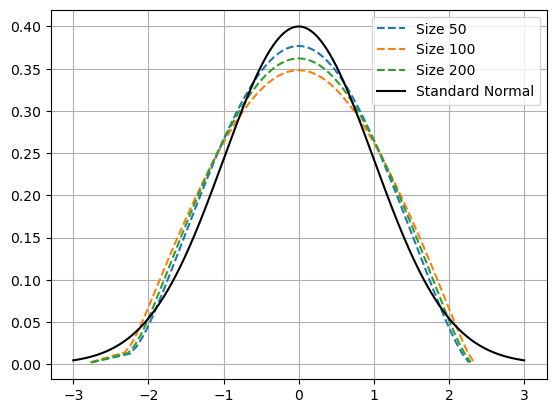

In [22]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="Size 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="Size 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="Size 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

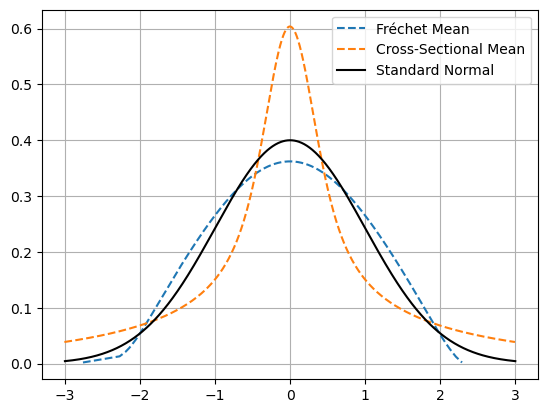

In [23]:
# Plot Fréchet mean vs cross-sectional mean and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x, mean_of_f_means200.y, label="Fréchet Mean", linestyle="--",
)
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Cross-Sectional Mean",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

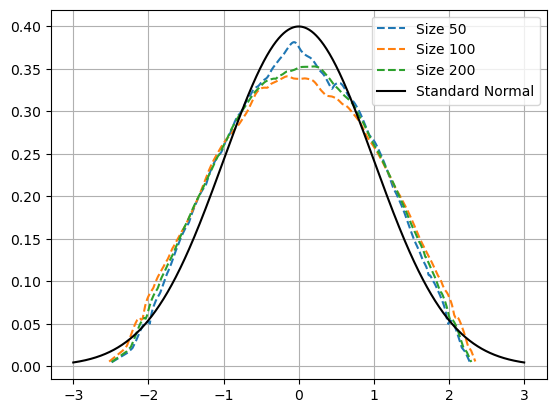

In [24]:
# Plot Fréchet means from estimated densities and of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means50_denstimation.x,
    mean_of_f_means50_denstimation.y,
    label="Size 50",
    linestyle="--",
)
ax.plot(
    mean_of_f_means100_denstimation.x,
    mean_of_f_means100_denstimation.y,
    label="Size 100",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Size 200",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

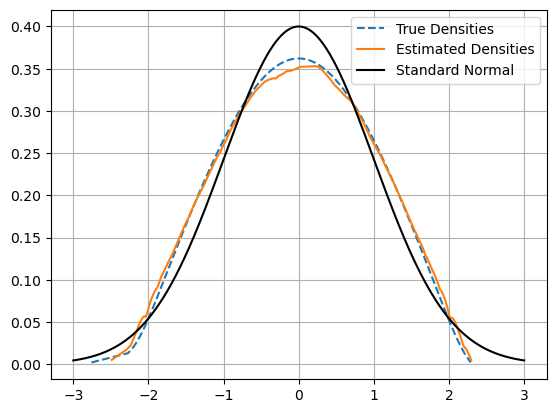

In [25]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="-",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

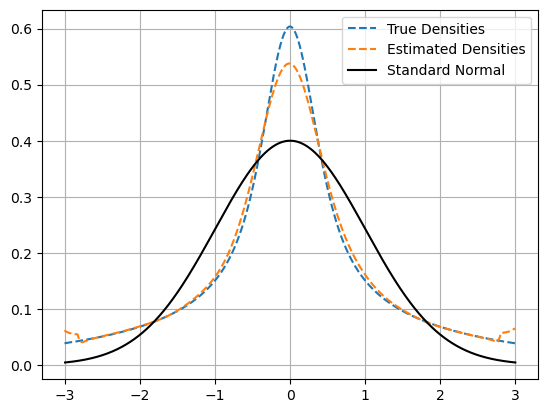

In [26]:
# Plot cross-sectional mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_cs_means200_denstimation.x,
    mean_of_cs_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

## Implement density estimation step

In [83]:
n = 200
grid_size = 1000
trunc = 3
bandwitherino = 1.2
mus, sigmas = gen_params_scenario_one(n, seed=123456)
sigmas.sort()

In [84]:
sample_points = gen_truncnorm_pdf_points(-trunc, trunc, mus, sigmas, 100)
pdf_hats = make_estimated_truncnorm_pdf(
    sample_points=sample_points,
    a=-trunc * np.ones(n),
    b=trunc * np.ones(n),
    kern="std_normal",
    grid_size=grid_size,
    bandwidth=bandwitherino,
)
new_ranges = get_optimal_range(pdf_hats)
# Generate numerically stable objects, within individual ranges
new_pdf_hats = make_estimated_truncnorm_pdf(
    sample_points=sample_points,
    a=new_ranges[:, 0],
    b=new_ranges[:, 1],
    kern="std_normal",
    grid_size=grid_size,
    bandwidth=bandwitherino,
)

[-2.89189189 -2.88588589 -2.87987988 -2.87387387 -2.86786787 -2.86186186
 -2.85585586 -2.84984985 -2.84384384 -2.83783784 -2.83183183 -2.82582583
 -2.81981982 -2.81381381 -2.80780781 -2.8018018  -2.7957958  -2.78978979
 -2.78378378 -2.77777778 -2.77177177 -2.76576577 -2.75975976 -2.75375375
 -2.74774775 -2.74174174 -2.73573574 -2.72972973 -2.72372372 -2.71771772
 -2.71171171 -2.70570571 -2.6996997  -2.69369369 -2.68768769 -2.68168168
 -2.67567568 -2.66966967 -2.66366366 -2.65765766 -2.65165165 -2.64564565
 -2.63963964 -2.63363363 -2.62762763 -2.62162162 -2.61561562 -2.60960961
 -2.6036036  -2.5975976  -2.59159159 -2.58558559 -2.57957958 -2.57357357
 -2.56756757 -2.56156156 -2.55555556 -2.54954955 -2.54354354 -2.53753754
 -2.53153153 -2.52552553 -2.51951952 -2.51351351 -2.50750751 -2.5015015
 -2.4954955  -2.48948949 -2.48348348 -2.47747748 -2.47147147 -2.46546547
 -2.45945946 -2.45345345 -2.44744745 -2.44144144 -2.43543544 -2.42942943
 -2.42342342 -2.41741742 -2.41141141 -2.40540541 -2.

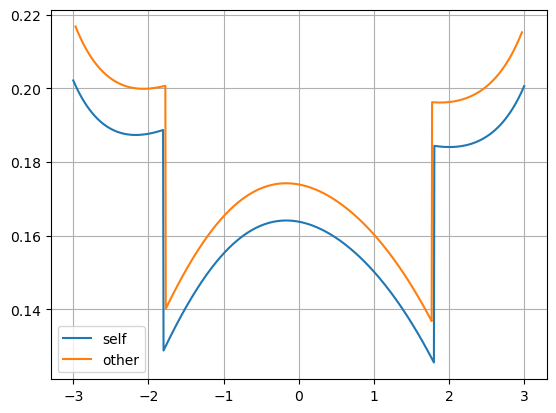

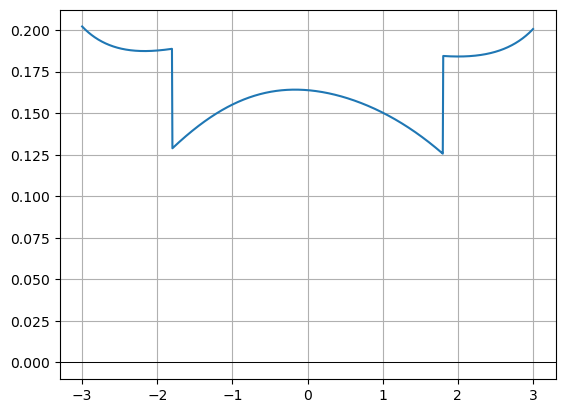

In [86]:
interesting_pdf = 150
pdf_hats[interesting_pdf].compare(new_pdf_hats[interesting_pdf] + 0.01)
pdf_hats[interesting_pdf].plot()